# Show samples on time domain

This notebook will show all the samples per dataset and class on frequency domain.

1. Calculate mean, minimum, and 75 percentil of samples
2. Calculate median, 25 percentil, and 75 percentil of samples
3. Plot the mean like line and 25/75 percentil like enveloping

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys
sys.path.append("../../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.har.loaders import WISDM_UnbalancedView20Hz
from librep.datasets.multimodal import PandasMultiModalDataset, TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.transforms. stats import StatsTransform
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-11 00:11:13.131814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 00:11:13.131834: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load WISDM

In [3]:
# WISDM Loader
loader = WISDM_UnbalancedView20Hz(
    "../../../data/views/WISDM/unbalanced_20Hz_train_test-v1", 
    download=False
)

In [4]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=10823, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=4373, features=360, no. window=6, label_columns='standard activity code')

In [5]:
train_val.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,user,standard activity code
0,-0.364761,-0.900995,1.988477,0.504245,-2.074267,-4.365631,-0.503460,1.585056,-0.192807,-1.778517,...,0.021654,-0.008257,-0.392786,-0.329143,-0.074698,-0.027220,0.314905,0,1600,2
1,0.081002,-0.059554,0.429260,1.072248,-2.011736,-4.792650,-2.087036,0.663866,0.317017,-1.504834,...,0.345166,0.294343,-0.417068,-0.172208,0.067521,0.406141,0.615971,0,1600,2
2,0.192588,-0.855499,-1.242746,0.316417,-1.833108,-4.946311,1.429507,1.555702,-1.230934,-2.758278,...,0.341863,0.039910,-0.253467,-0.607339,-0.102324,0.100644,0.608968,0,1600,2
3,1.506239,-1.887573,-0.375515,0.282729,-2.745547,-5.598461,-1.923976,1.519264,0.538521,-2.826598,...,0.408067,0.268658,-0.341150,-0.359142,-0.065309,-0.015974,0.365056,0,1600,2
4,-0.494237,-0.791543,0.976555,1.730751,-4.135104,-7.033570,-3.470397,-1.347896,0.434743,0.326745,...,-0.459501,0.421399,-0.182202,-0.406128,-0.590792,-0.174049,0.307581,0,1600,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10818,-0.705972,-0.726914,-0.808348,-0.727646,-0.519297,-0.706294,-0.778460,-0.935760,-0.656630,-0.765051,...,0.015264,0.003391,-0.007575,0.000763,0.015584,-0.014311,-0.016027,4,1635,1
10819,-0.608502,-0.795883,-0.552300,-0.851302,-0.894535,-0.706040,-0.784716,-0.855779,-0.704870,-0.683281,...,-0.003144,-0.002943,0.005729,-0.010290,-0.006023,-0.006458,-0.001189,4,1635,1
10820,-0.777215,-0.714181,-0.765897,-0.765035,-0.697754,-0.852415,-0.749396,-0.637518,-0.757676,-0.702906,...,-0.001254,0.006774,-0.001247,0.001032,0.006439,0.005181,0.011468,4,1635,1
10821,-1.073461,-0.614644,-0.764390,-0.546810,-0.874834,-0.619953,-0.698473,-0.924804,-0.704255,-0.736017,...,0.004119,0.000570,-0.035448,-0.028324,0.004960,0.002800,-0.004581,4,1635,1


In [6]:
train_val.data.describe()

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
count,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,...,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000,10823.000000
mean,-0.105190,-0.097713,-0.061938,-0.079331,-0.136161,-0.210600,-0.165041,-0.188723,-0.155305,-0.174346,...,-0.008437,-0.009272,-0.006242,-0.007047,-0.015948,-0.008439,-0.007900,-0.020075,-0.012868,-0.004171
std,5.286732,5.228431,5.265864,5.232591,5.228650,5.236718,5.217191,5.257057,5.202087,5.163136,...,0.909097,0.930740,0.944661,0.928317,0.972496,0.965848,0.942276,0.946214,0.959424,0.978382
min,-23.451251,-21.201263,-20.116584,-20.680624,-21.254168,-20.442931,-21.703637,-21.339970,-20.947055,-21.019733,...,-11.952176,-7.664606,-9.737739,-10.652704,-12.109685,-8.862850,-9.235783,-11.865164,-10.336521,-10.386520
25%,-3.088468,-3.096602,-3.044383,-3.068328,-3.130675,-3.222249,-3.126423,-3.171965,-3.081922,-3.095960,...,-0.186443,-0.177458,-0.165249,-0.171662,-0.183985,-0.170109,-0.179099,-0.186572,-0.188080,-0.180611
50%,-0.093611,-0.143521,-0.131110,-0.081606,-0.125065,-0.136131,-0.111269,-0.114529,-0.122918,-0.128595,...,-0.000825,-0.000982,-0.000710,-0.000750,-0.000941,-0.000973,-0.001175,-0.001541,-0.001194,-0.001025
75%,3.122589,3.127022,3.108404,3.048547,3.062237,3.027269,3.060705,3.111957,3.060319,3.080721,...,0.165555,0.160202,0.165026,0.170143,0.167101,0.175787,0.162238,0.149386,0.166146,0.171061
max,20.248555,19.779669,21.459666,22.167043,20.678980,22.783820,20.001859,22.675548,19.449384,21.842399,...,7.893185,8.695147,8.765377,8.302051,9.979406,12.063560,8.778277,8.056754,10.651924,10.160658


In [7]:
from librep.datasets.multimodal import ArrayMultiModalDataset

# Train
train = ArrayMultiModalDataset(
    X=np.array(train_val.data.iloc[:,:-3]), y=np.array(train_val.data['standard activity code']),
    window_slices=train_val.window_slices,
    window_names=train_val.window_names,
)

# Prepare the data

In [8]:
class_names = {
    0: "Sit",
    1: "Stand", 
    2: "Walk",
    3: "Upstairs",
    4: "Downstairs",
    5: "Run / Jogging",
    6: "stair up and down"
}

In [9]:
# def plot(data_fft, classes_names):
def max_norm(v):
    norm = max(np.abs(v))
    return norm

def plot_mean(data_fft, class_names):
    
    classes = np.unique(data_fft.y)
    time_axi = np.linspace(0,3,60)

    samples_per_activity = {i:[] for i in range(7)}
    mean_samples_per_activity = {i:[] for i in range(7)}
    max_samples = {i:[] for i in range(7)}
    min_samples = {i:[] for i in range(7)}
    
    percentil_5_sample = {i:[] for i in range(7)}
    percentil_95_sample = {i:[] for i in range(7)}

    for sample, label in data_fft:
        sam = np.reshape(sample, (6,60))

        new_sample = []
        for sensor_axi in sam:
            # norm = max_norm(sensor_axi)
            norm = 1.
            new_sample.append(sensor_axi / norm)

        new_sample = np.array(new_sample)
        samples_per_activity[label].append(new_sample)

    for i in classes:
        mean_samples_per_activity[i] = np.reshape(np.mean(samples_per_activity[i], axis=0), (6,60))
        min_samples[i] = np.reshape(np.min(samples_per_activity[i], axis=0), 
                                            (6,60))
        max_samples[i] = np.reshape(np.max(samples_per_activity[i], axis=0), 
                                            (6,60))

    sensors = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
    num_data, tam_data = 6, 60

    for classe in classes:
        fig, axs = plt.subplots(nrows=num_data, ncols=1, figsize=(7,7), sharey=False)
        aux =[]
        axs[0].set_title('Envelope da média das séries temporais da classe {} - Dataset: WISDM'.format(class_names[classe]))
        for j in range(num_data):
            axs[j].set_ylabel("Magnitude")
            axs[j].set_xlabel("Time (seg.) - Sensor: {}".format(sensors[j]))
            axs[j].set_xlim(0,3)
            axs[j].plot(time_axi, mean_samples_per_activity[classe][j], color='C1', label="Mean")
            axs[j].plot(time_axi, min_samples[classe][j], color='C4', label="Min")
            axs[j].plot(time_axi, max_samples[classe][j], color='C4', label="Max")
            axs[j].fill_between(time_axi, min_samples[classe][j], 
                                max_samples[classe][j], alpha=0.3)
            axs[j].grid()

            fig.tight_layout() 
            plt.legend()

        plt.show()
        
        
def plot_median(data_fft, class_names):
    
    classes = np.unique(data_fft.y)
    time_axi = np.linspace(0,3,60)

    samples_per_activity = {i:[] for i in range(7)}
    median_samples_per_activity = {i:[] for i in range(7)}
    
    percentil_25_sample = {i:[] for i in range(7)}
    percentil_75_sample = {i:[] for i in range(7)}

    for sample, label in data_fft:
        sam = np.reshape(sample, (6,60))

        new_sample = []
        for sensor_axi in sam:
            # norm = max_norm(sensor_axi)
            norm = 1.
            new_sample.append(sensor_axi / norm)

        new_sample = np.array(new_sample)
        samples_per_activity[label].append(new_sample)

    for i in classes:
        median_samples_per_activity[i] = np.reshape(np.median(samples_per_activity[i], axis=0), (6,60))
        percentil_25_sample[i] = np.reshape(np.percentile(samples_per_activity[i], 25, axis=0), 
                                            (6,60))
        percentil_75_sample[i] = np.reshape(np.percentile(samples_per_activity[i], 75, axis=0), 
                                            (6,60))

    sensors = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
    num_data, tam_data = 6, 60

    for classe in classes:
        fig, axs = plt.subplots(nrows=num_data, ncols=1, figsize=(7, 7), sharey=False)
        aux =[]
        axs[0].set_title('Envelope da mediana das séries temporais da classe {} - Dataset: WISDM'.format(class_names[classe]))
        for j in range(num_data):
            axs[j].set_ylabel("Amplitude")
            axs[j].set_xlabel("Time (seg.) - Sensor: {}".format(sensors[j]))
            axs[j].set_xlim(0,3)
            axs[j].plot(time_axi, median_samples_per_activity[classe][j], color='C1', label="Median")
            axs[j].plot(time_axi, percentil_25_sample[classe][j], color='C4', label="25 percentil")
            axs[j].plot(time_axi, percentil_75_sample[classe][j], color='C4', label="75 percentil")
            axs[j].fill_between(time_axi, percentil_25_sample[classe][j], 
                                percentil_75_sample[classe][j], alpha=0.3)
            axs[j].grid()

            fig.tight_layout() 
            plt.legend()

        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


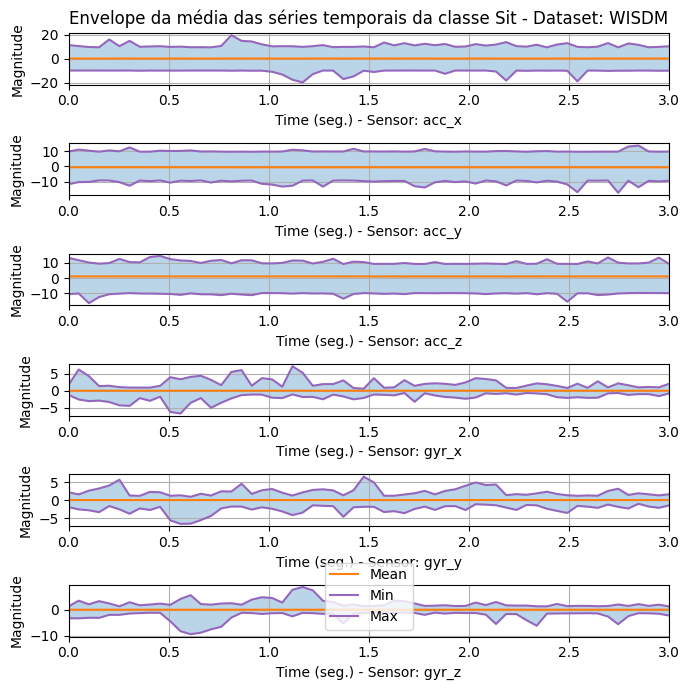

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


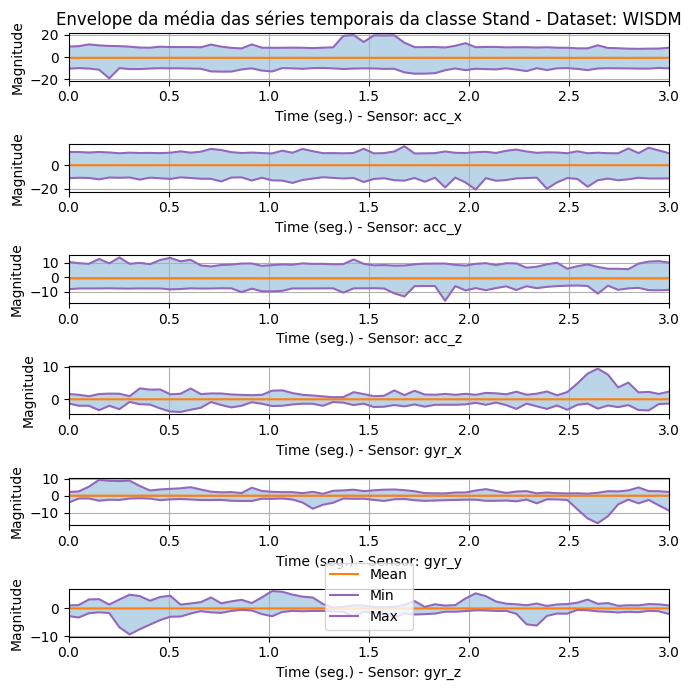

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


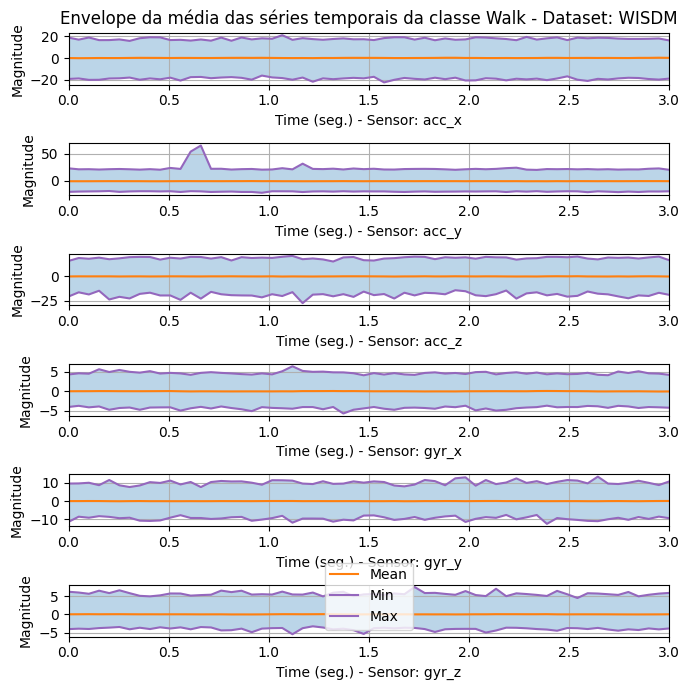

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


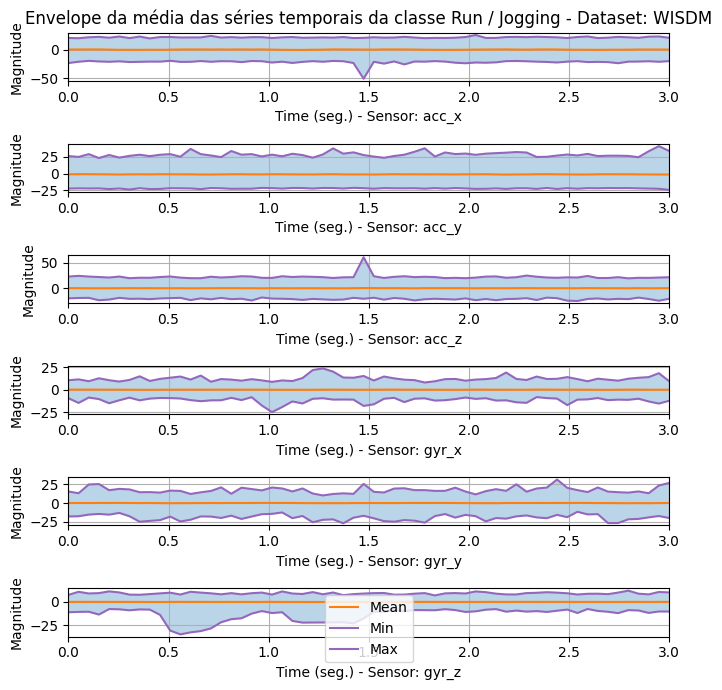

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


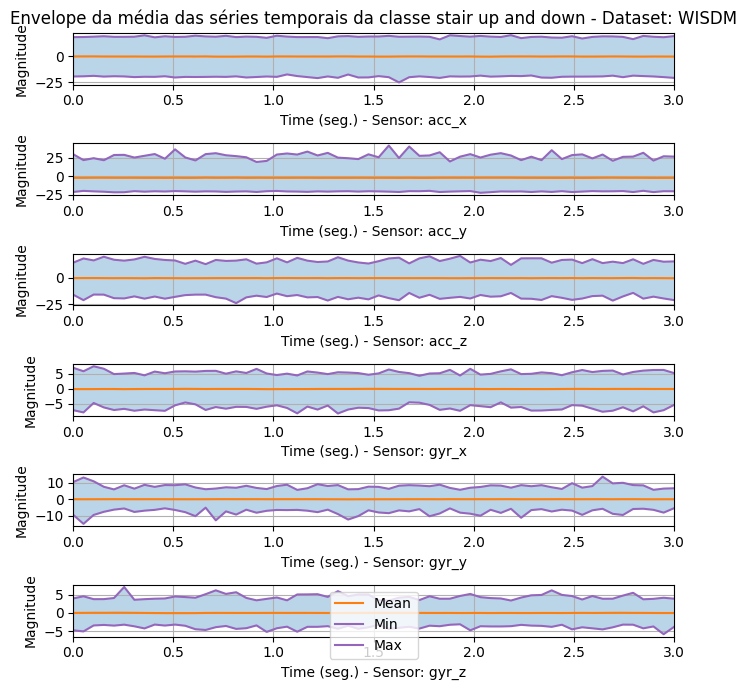

In [10]:
plot_mean(train, class_names)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


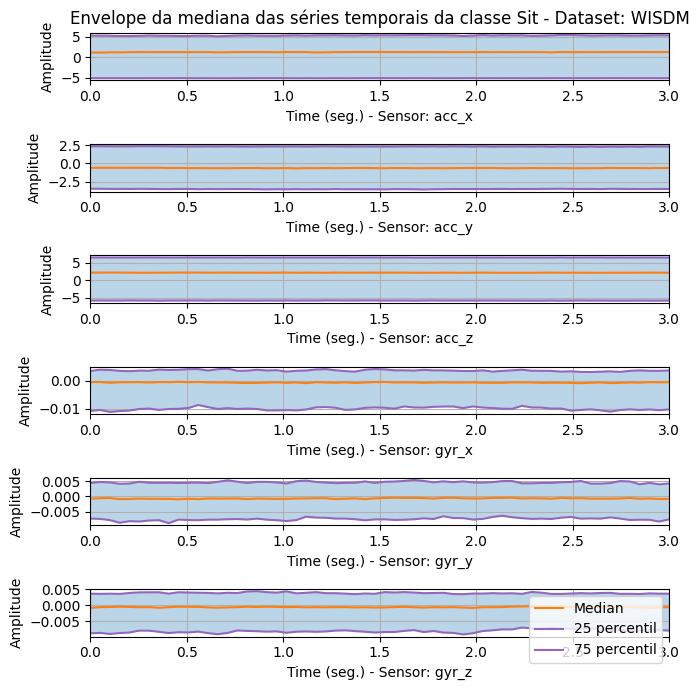

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


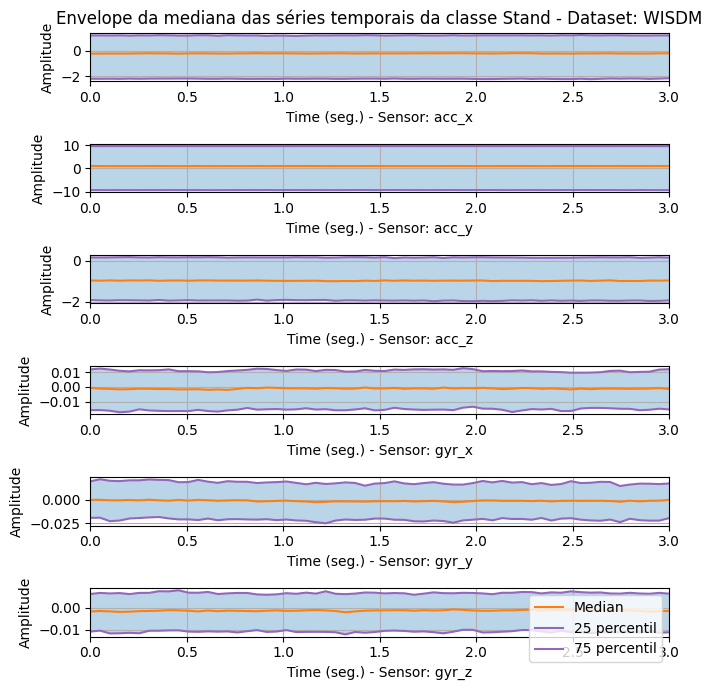

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


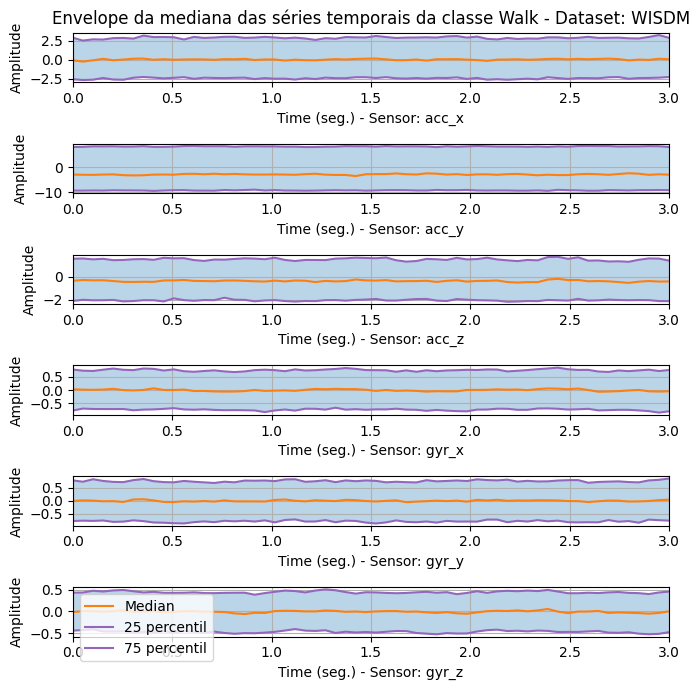

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


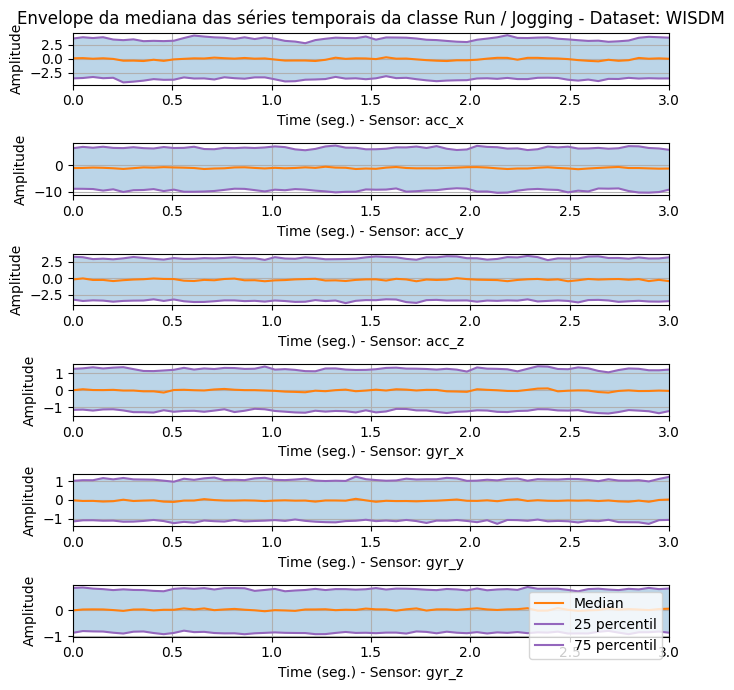

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


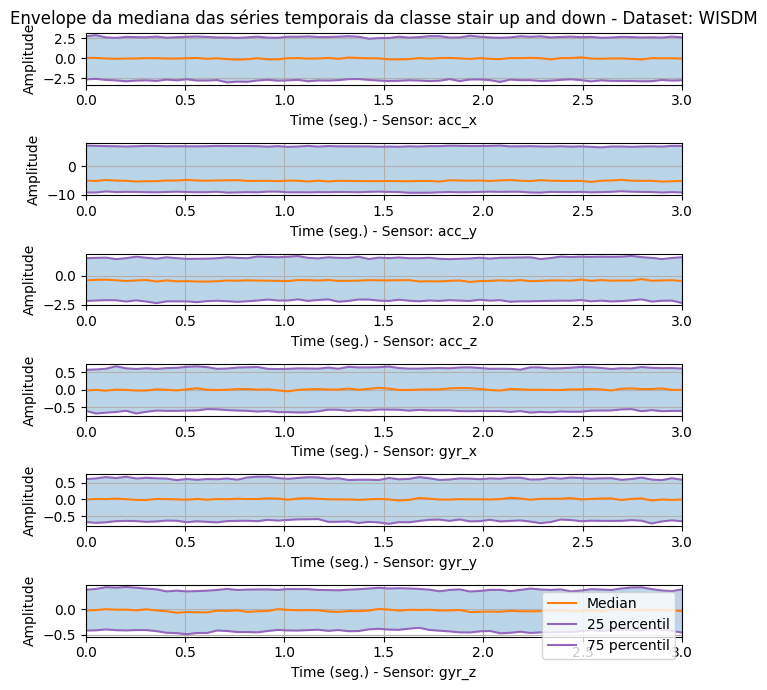

In [11]:
plot_median(train, class_names)

# t-SNE and UMAP

In [12]:
def plot(df, figsize: tuple = (8, 8), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label)
    ax.legend()
    plt.title(title)
    plt.show()

In [13]:
labels = {0: "Sit", 1: "Stand", 2: "Walk", 3: "Stair up", 4: "Stair down", 5: "Run"}
print(labels)

{0: 'Sit', 1: 'Stand', 2: 'Walk', 3: 'Stair up', 4: 'Stair down', 5: 'Run'}


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyError: 6

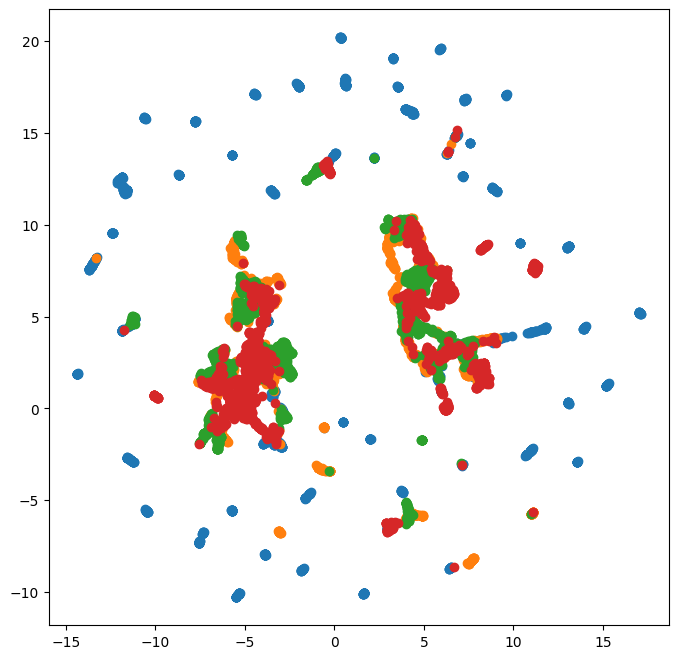

In [14]:
model = UMAP(n_components=2)
result = pd.DataFrame(model.fit_transform(train[:][0]), columns=["x", "y"])
result["label"] = train[:][1]
plot(result, title="UMAP on WISDM data", labels = labels)

In [ ]:
model = TSNE(n_components=2)
result = pd.DataFrame(model.fit_transform(train[:][0]), columns=["x", "y"])
result["label"] = train[:][1]
plot(result, title="T-SNE on WISDM data", labels=labels)

In [ ]:
train[:][1]